### P2P Lending System

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Import

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = "https://drive.google.com/file/d/1aGf9sDBY0-7UAsO2l7w9lxKBtO954bv4/view?usp=sharing"
id = "1aGf9sDBY0-7UAsO2l7w9lxKBtO954bv4"

In [4]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Master_Loan_Summary.csv')  
df = pd.read_csv('Master_Loan_Summary.csv')
# Dataset is now stored in a Pandas Dataframe


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### EDA

In [6]:
df.head()

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,origination_date,listing_title,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,last_payment_date,next_payment_due_date,days_past_due,loan_status_description,data_source
0,10149342,27050.0,36,0.1099,885.46,B,2013-12-01T00:00,debt_consolidation,0.0,27050.0,4702.53,0.0,0.0,2016-07-01T00:00,2016-08-01T00:00,0,COMPLETED,Lending Club
1,10149488,4800.0,36,0.1099,157.13,B,2013-12-01T00:00,home_improvement,0.0,4800.0,357.52,0.0,0.0,2014-09-01T00:00,2014-10-01T00:00,0,COMPLETED,Lending Club
2,10148122,12000.0,36,0.0762,373.94,A,2013-12-01T00:00,debt_consolidation,0.0,12000.0,1397.54,0.0,0.0,2016-06-01T00:00,2016-07-01T00:00,0,COMPLETED,Lending Club
3,10119623,12000.0,36,0.1199,398.52,B,2013-12-01T00:00,debt_consolidation,0.0,12000.0,2346.48,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club
4,10159498,12000.0,36,0.0662,368.45,A,2013-12-01T00:00,debt_consolidation,0.0,12000.0,1263.95,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club


In [7]:
df.shape

(2875146, 18)

In [8]:
df['loan_status_description'].value_counts()

CURRENT      1381520
COMPLETED    1173162
CHARGEOFF     222867
DEFAULTED      95344
CANCELLED       2253
Name: loan_status_description, dtype: int64

**Countplot of Target Varaible**

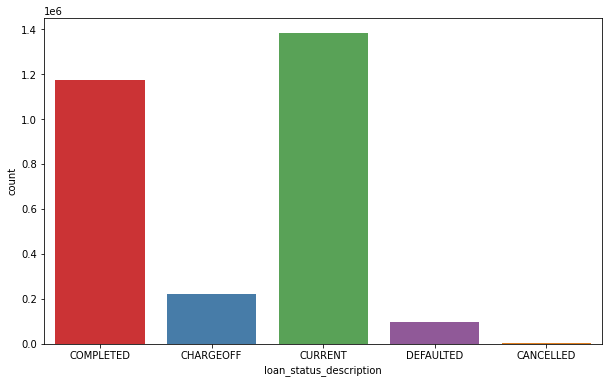

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x='loan_status_description', data=df, palette='Set1')

**Histogram of amount_borrowed**

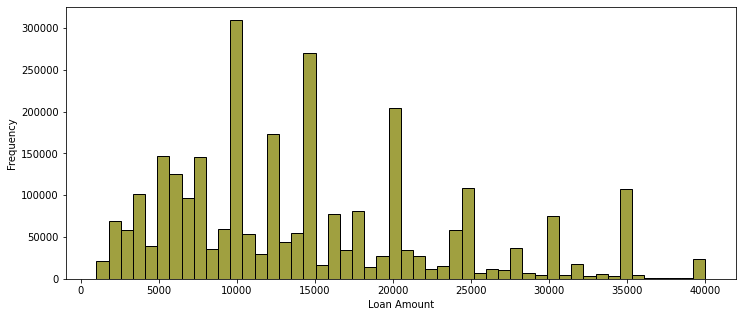

In [10]:
plt.figure(figsize=(12,5))
ax = sns.histplot(data=df, x='amount_borrowed',bins=50, color='olive')
ax.set(xlabel='Loan Amount', ylabel='Frequency')
plt.show()

**Correlation Heatmap**

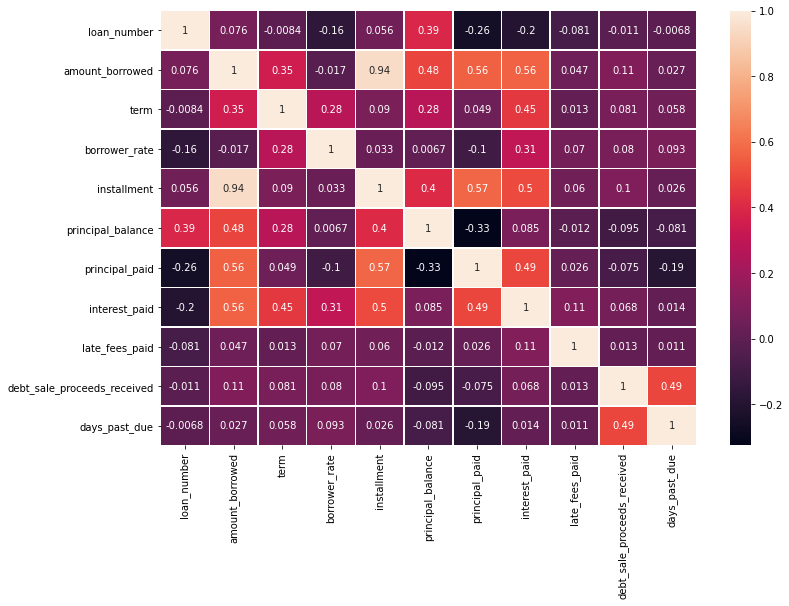

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, linewidths=0.5)


**intallment - amount_borrowed plot**

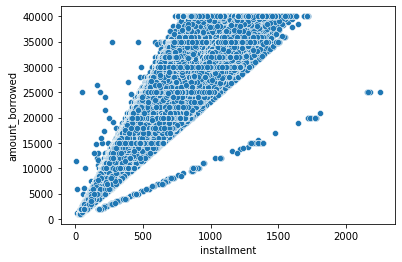

In [12]:
sns.scatterplot(x='installment', y='amount_borrowed', data=df)

**loan_status_prediction - amount_borrowed box plot**

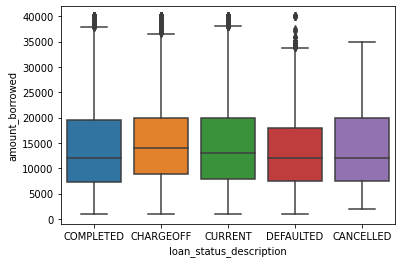

In [13]:
sns.boxplot(x='loan_status_description', y='amount_borrowed', data=df)

**Grade Count Plot**

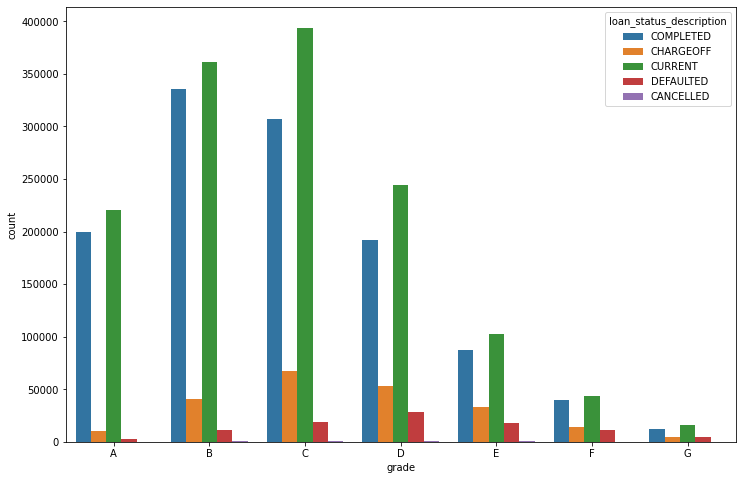

In [14]:
grade_order = sorted(df['grade'].unique())
plt.figure(figsize=(12,8))
sns.countplot(x='grade', data=df, hue='loan_status_description', order=grade_order)

**Data Source Count Plot**

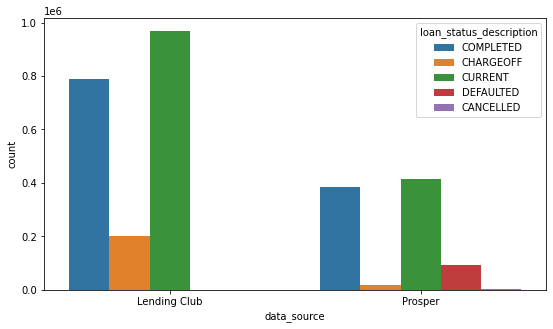

In [15]:
plt.figure(figsize=(9,5))
sns.countplot(x='data_source', data=df, hue='loan_status_description')

### Data Processing

In [16]:
df.head()

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,origination_date,listing_title,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,last_payment_date,next_payment_due_date,days_past_due,loan_status_description,data_source
0,10149342,27050.0,36,0.1099,885.46,B,2013-12-01T00:00,debt_consolidation,0.0,27050.0,4702.53,0.0,0.0,2016-07-01T00:00,2016-08-01T00:00,0,COMPLETED,Lending Club
1,10149488,4800.0,36,0.1099,157.13,B,2013-12-01T00:00,home_improvement,0.0,4800.0,357.52,0.0,0.0,2014-09-01T00:00,2014-10-01T00:00,0,COMPLETED,Lending Club
2,10148122,12000.0,36,0.0762,373.94,A,2013-12-01T00:00,debt_consolidation,0.0,12000.0,1397.54,0.0,0.0,2016-06-01T00:00,2016-07-01T00:00,0,COMPLETED,Lending Club
3,10119623,12000.0,36,0.1199,398.52,B,2013-12-01T00:00,debt_consolidation,0.0,12000.0,2346.48,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club
4,10159498,12000.0,36,0.0662,368.45,A,2013-12-01T00:00,debt_consolidation,0.0,12000.0,1263.95,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club


**Dropping Rows with Completed and Current loan_status_description**

Here, I will remove the current and cancelled, as we can predict whether the current and cancelled loans would fall into completed, current or defaulted category.

In [17]:
df = df[((df['loan_status_description'] != 'CURRENT') & (df['loan_status_description'] != 'CANCELLED'))]

In [18]:
df['loan_status_description'].value_counts()

COMPLETED    1173162
CHARGEOFF     222867
DEFAULTED      95344
Name: loan_status_description, dtype: int64

**Converting loan_status_description (String) to numerical**

In [19]:
df['loan_status_description'] = df['loan_status_description'].map({'COMPLETED':0, 'CHARGEOFF':1, 'DEFAULTED':2})

In [20]:
df['loan_status_description'].value_counts()

0    1173162
1     222867
2      95344
Name: loan_status_description, dtype: int64

**Checking Null Values**

In [21]:
df.isnull().sum()

loan_number                         0
amount_borrowed                     0
term                                0
borrower_rate                       0
installment                         0
grade                               0
origination_date                    0
listing_title                  487360
principal_balance                   0
principal_paid                      0
interest_paid                       0
late_fees_paid                      0
debt_sale_proceeds_received         0
last_payment_date                   0
next_payment_due_date               0
days_past_due                       0
loan_status_description             0
data_source                         0
dtype: int64

**Checking Null Value Percentage**

In [22]:
(df.isnull().sum()/df.shape[0])*100

loan_number                     0.000000
amount_borrowed                 0.000000
term                            0.000000
borrower_rate                   0.000000
installment                     0.000000
grade                           0.000000
origination_date                0.000000
listing_title                  32.678612
principal_balance               0.000000
principal_paid                  0.000000
interest_paid                   0.000000
late_fees_paid                  0.000000
debt_sale_proceeds_received     0.000000
last_payment_date               0.000000
next_payment_due_date           0.000000
days_past_due                   0.000000
loan_status_description         0.000000
data_source                     0.000000
dtype: float64

**Handling Null Values of listing_title Feature**

Here we will consider all Null values in listing_title as 'other'.

In [23]:
df['listing_title'].value_counts()

debt_consolidation    595511
credit_card           218391
home_improvement       63750
other                  54010
major_purchase         20235
medical                10944
small_business         10909
car                    10001
moving                  6723
vacation                6511
house                   4924
wedding                 1459
renewable_energy         644
educational                1
Name: listing_title, dtype: int64

In [24]:
df['listing_title'].fillna(value = 'other', inplace = True)

In [25]:
df['listing_title'].value_counts()

debt_consolidation    595511
other                 541370
credit_card           218391
home_improvement       63750
major_purchase         20235
medical                10944
small_business         10909
car                    10001
moving                  6723
vacation                6511
house                   4924
wedding                 1459
renewable_energy         644
educational                1
Name: listing_title, dtype: int64

In [26]:
df.isnull().sum()

loan_number                    0
amount_borrowed                0
term                           0
borrower_rate                  0
installment                    0
grade                          0
origination_date               0
listing_title                  0
principal_balance              0
principal_paid                 0
interest_paid                  0
late_fees_paid                 0
debt_sale_proceeds_received    0
last_payment_date              0
next_payment_due_date          0
days_past_due                  0
loan_status_description        0
data_source                    0
dtype: int64

**Dataset Categorical Columns**

In [27]:
df.dtypes[df.dtypes == object]

grade                    object
origination_date         object
listing_title            object
last_payment_date        object
next_payment_due_date    object
data_source              object
dtype: object

Here we will drop loan origination_date, as we do not know yet if the loan is approved or not.

Also, we will be removing last_payment_date because every loan can have same or different dates, and it will not help in categorizing loan_status_description.

next_payment_due_date will be no use if loan_status is completed, defaulted or charged_off

In [28]:
df.drop(columns=['origination_date', 'last_payment_date', 'next_payment_due_date'], inplace=True)

**Converting grade, listing_title, data_source into dummy variable**

In [29]:
df = pd.get_dummies(df, columns = ['grade', 'listing_title', 'data_source'], drop_first = True)

In [30]:
df

,loan_number,amount_borrowed,term,borrower_rate,installment,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,days_past_due,loan_status_description,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,listing_title_credit_card,listing_title_debt_consolidation,listing_title_educational,listing_title_home_improvement,listing_title_house,listing_title_major_purchase,listing_title_medical,listing_title_moving,listing_title_other,listing_title_renewable_energy,listing_title_small_business,listing_title_vacation,listing_title_wedding,data_source_Prosper
0,10149342,27050.0,36,0.1099,885.460000,0.0,27050.0,4702.53,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,10149488,4800.0,36,0.1099,157.130000,0.0,4800.0,357.52,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,10148122,12000.0,36,0.0762,373.940000,0.0,12000.0,1397.54,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,10119623,12000.0,36,0.1199,398.520000,0.0,12000.0,2346.48,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,10159498,12000.0,36,0.0662,368.450000,0.0,12000.0,1263.95,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874654,1080060,20000.0,36,0.0839,630.331835,0.0,20000.0,218.63,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2874846,1073951,6000.0,36,0.0894,190.630891,0.0,6000.0,0.51,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2874929,1073195,6000.0,36,0.2784,247.663171,0.0,6000.0,64.07,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2875013,1081659,15000.0,36,0.2644,607.880629,0.0,15000.0,528.54,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


**Dataset Continous Variables**

Every loan has a unique loan_number, and can be removed.

In [31]:
df.drop('loan_number', inplace=True, axis=1)

**Converting term into dummy variable**

In [32]:
df.term.value_counts()

36    1126468
60     364633
12        272
Name: term, dtype: int64

As term has only three values, it can be converted to dummy variable.

In [33]:
df = pd.get_dummies(df, columns=['term'], drop_first=True)

In [34]:
df.head()

,amount_borrowed,borrower_rate,installment,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,days_past_due,loan_status_description,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,listing_title_credit_card,listing_title_debt_consolidation,listing_title_educational,listing_title_home_improvement,listing_title_house,listing_title_major_purchase,listing_title_medical,listing_title_moving,listing_title_other,listing_title_renewable_energy,listing_title_small_business,listing_title_vacation,listing_title_wedding,data_source_Prosper,term_36,term_60
0,27050.0,0.1099,885.46,0.0,27050.0,4702.53,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4800.0,0.1099,157.13,0.0,4800.0,357.52,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,12000.0,0.0762,373.94,0.0,12000.0,1397.54,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,12000.0,0.1199,398.52,0.0,12000.0,2346.48,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,12000.0,0.0662,368.45,0.0,12000.0,1263.95,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**Multicollinearity Check with VIF on Continous Variables**

In [35]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [36]:
# VIF Multicollinearity check
X = df[['amount_borrowed', 'borrower_rate',
       'installment', 'principal_balance', 'principal_paid', 'interest_paid',
       'late_fees_paid', 'debt_sale_proceeds_received', 'days_past_due']]
vif = calc_vif(X)
vif[vif['VIF']>10]

,variables,VIF
0,amount_borrowed,56.549154
2,installment,44.423913
4,principal_paid,13.951818


Here I have take VIF threshold = 10. Given the above result, I am removing amount_borrowed which has highest VIF and run VIF again.

In [37]:
X.drop('amount_borrowed', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
vif = calc_vif(X)
vif[vif['VIF']>10]

,variables,VIF
1,installment,14.562109
3,principal_paid,11.514846


Now, removing installment and checking VIF again.

In [39]:
X.drop('installment', axis = 1, inplace= True)
vif = calc_vif(X)
vif[vif['VIF']>10]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,variables,VIF


Now, df continous variables have no feature having VIF > 10.

### Model Building

**Neural Network Model**




In [40]:
# Removing amount_borrowed, installment from df
df.drop(['installment', 'amount_borrowed'], axis = 1, inplace= True)

In [41]:
df.head()

,borrower_rate,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,days_past_due,loan_status_description,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,listing_title_credit_card,listing_title_debt_consolidation,listing_title_educational,listing_title_home_improvement,listing_title_house,listing_title_major_purchase,listing_title_medical,listing_title_moving,listing_title_other,listing_title_renewable_energy,listing_title_small_business,listing_title_vacation,listing_title_wedding,data_source_Prosper,term_36,term_60
0,0.1099,0.0,27050.0,4702.53,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.1099,0.0,4800.0,357.52,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0762,0.0,12000.0,1397.54,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.1199,0.0,12000.0,2346.48,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0662,0.0,12000.0,1263.95,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [42]:
X = df.drop('loan_status_description', axis = 1)
y = df['loan_status_description']

In [43]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [44]:
# Normalising dataset
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
X.shape

(1491373, 29)

In [46]:
# Building Neural Network Model
model = Sequential()

# Adding Input Layer
model.add(Dense(29, activation='relu'))
model.add(Dropout(0.2)) # This will help in regularization

# Hidden Layer
model.add(Dense(14, activation='relu'))
model.add(Dropout(0.2))

# Hidden Layer
model.add(Dense(7, activation='relu'))
model.add(Dropout(0.2))

# Output Layer. We will add activation as it is binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [47]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 

In [48]:
# Fitting Model
model.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test), batch_size = 256)

Epoch 1/100
4661/4661 [==============================] - 22s 4ms/step - loss: -1127.7726 - val_loss: -5316.3970
Epoch 2/100
4661/4661 [==============================] - 18s 4ms/step - loss: -22380.8555 - val_loss: -53049.3594
Epoch 3/100
4661/4661 [==============================] - 18s 4ms/step - loss: -116259.2266 - val_loss: -214282.7969
Epoch 4/100
4661/4661 [==============================] - 17s 4ms/step - loss: -363096.4062 - val_loss: -590834.6250
Epoch 5/100
4661/4661 [==============================] - 17s 4ms/step - loss: -873742.3125 - val_loss: -1299953.0000
Epoch 6/100
4661/4661 [==============================] - 17s 4ms/step - loss: -1766010.1250 - val_loss: -2499543.2500
Epoch 7/100
4661/4661 [==============================] - 17s 4ms/step - loss: -3237516.2500 - val_loss: -4378968.0000
Epoch 8/100
4661/4661 [==============================] - 18s 4ms/step - loss: -5424987.5000 - val_loss: -7129155.0000
Epoch 9/100
4661/4661 [==============================] - 17s 4ms/step -

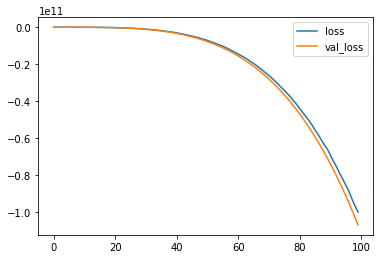

In [49]:
# Loss Comparison between training and test
losses = pd.DataFrame(model.history.history)
losses.plot()

In [50]:
# Predictions
predictions = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [51]:
print(confusion_matrix(y_test, predictions))

[[219682  14706      0]
 [  3921  40806      0]
 [  2494  16666      0]]


In [52]:
print(classification_report(y_test, predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      0.94      0.95    234388
           1       0.57      0.91      0.70     44727
           2       0.00      0.00      0.00     19160

    accuracy                           0.87    298275
   macro avg       0.51      0.62      0.55    298275
weighted avg       0.85      0.87      0.85    298275



**Random Forest Model**

In [53]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
rfc_pred = rfc.predict(X_test)

In [55]:
print(confusion_matrix(y_test,rfc_pred))

[[234168      0    220]
 [     0  44111    616]
 [   740    881  17539]]


In [56]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    234388
           1       0.98      0.99      0.98     44727
           2       0.95      0.92      0.93     19160

    accuracy                           0.99    298275
   macro avg       0.98      0.97      0.97    298275
weighted avg       0.99      0.99      0.99    298275

